In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import seaborn as sns

np.random.seed(84)

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

out_data_path = "../data/"

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.23.5 scipy==1.10.0 pandas==1.5.3 scikit-learn==1.2.1 statsmodels==0.13.5 python-igraph==0.10.5 pynndescent==0.5.10


### Load the Data

In [3]:
# Load the data output in 3_regression script
regressed_data_path = out_data_path + "regressed_ad.h5ad"
adata = ad.read_h5ad(regressed_data_path)

In [4]:
adata

AnnData object with n_obs × n_vars = 20248 × 30267
    obs: 'dataset', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'S_score', 'G2M_score', 'phase', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'phase_colors', 'scrublet', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## Gene expression

/Users/nellia/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


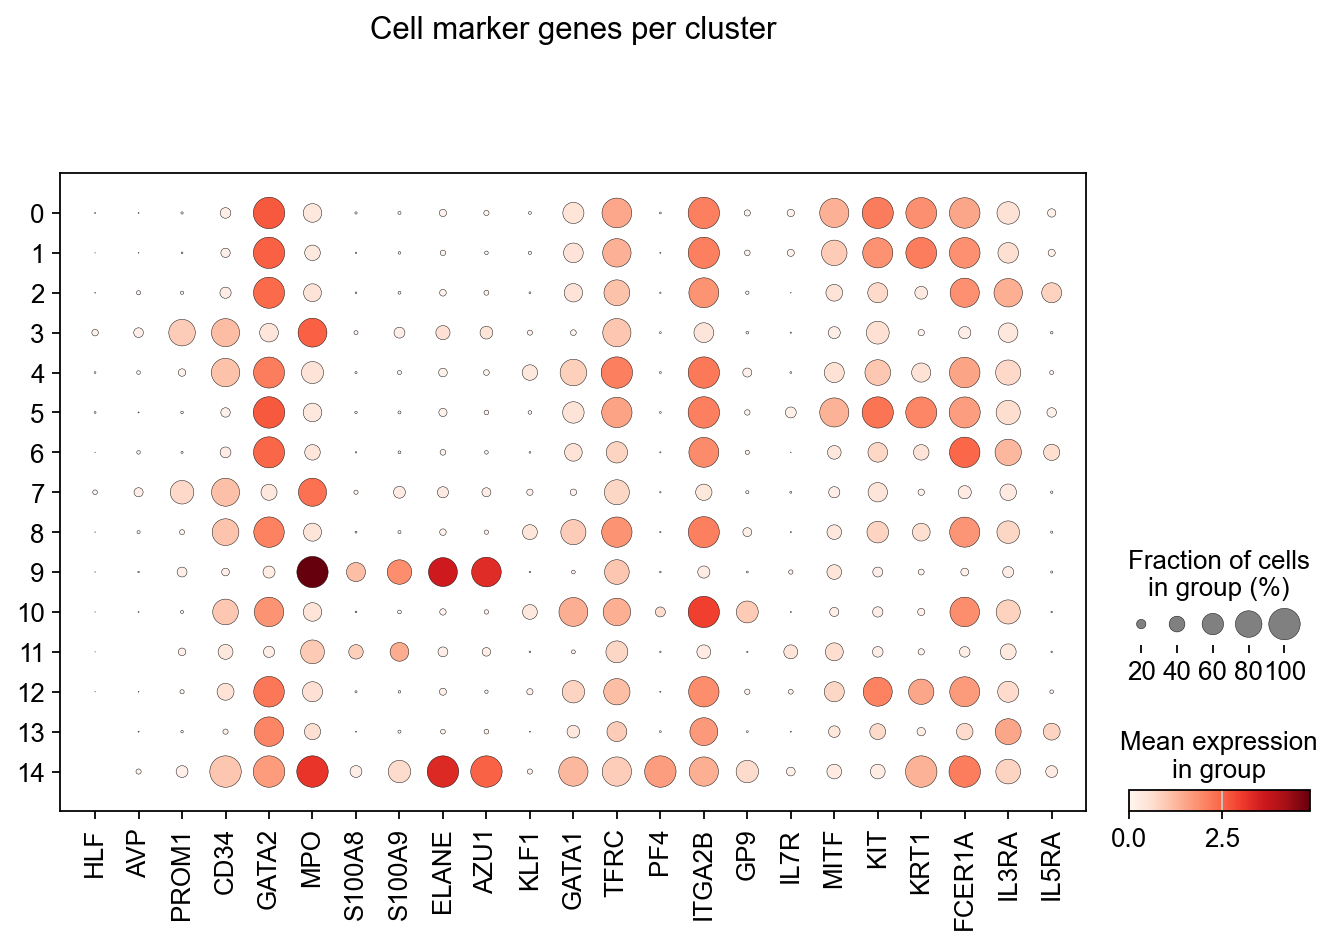

In [5]:
# Check the presense of marker genes in clusters
markers = ['HLF', 'AVP', 'PROM1', 'CD34', 'GATA2', 'MPO', 'S100A8', 'S100A9', 
             'ELANE', 'AZU1', 'KLF1', 'GATA1', 'TFRC', 'PF4', 'ITGA2B', 'GP9', 'IL7R', 'MITF','KIT', 
             'KRT1', 'FCER1A','IL3RA','IL5RA']

sc.pl.dotplot(adata, markers, groupby='leiden', title='Cell marker genes per cluster')

### Annotate Cells

In [6]:
celltype_markers = {'HSC':['PROM1','AVP','HLF'],
                    'HSPC':['PROM1','CD34'],
                    'Myeloid':['MPO', 'S100A8', 'S100A9', 'ELANE', 'AZU1'],
                    'Erythroid':['KLF1', 'GATA1', 'TFRC'],
                    'MK':['PF4', 'ITGA2B', 'GP9'],
                    'MAST':['KIT', 'KRT1'],
                    'Lymphoid':['IL7R', 'CD7', 'MME']}

In [7]:
# Manually annotate the cells
for cell_type, marker_genes in celltype_markers.items():
    
    # Set up the string using the cell population name
    cell_expr = cell_type + '_expr'
    cell_col = cell_type + '_cell'
    
    num_genes = len(marker_genes) # number of marker genes
    adata.obs[cell_expr] = 0 # set the initial marker expression value
    
    # Sum all the marker gene expressions
    for marker in marker_genes:
        adata.obs[cell_expr] = adata.obs[cell_expr] + adata[:, marker].to_df()[marker]
    
    adata.obs[cell_expr] = adata.obs[cell_expr] / num_genes # average of the expression
    
    thresh = (max(adata.obs[cell_expr]) + min(adata.obs[cell_expr])) / 4 # threshold calculation
    
    # Annotate the cells
    adata.obs[cell_col] = 'other'
    adata.obs[cell_col][adata.obs[cell_expr] > thresh] = cell_type

/var/folders/rh/sbn538812s14zjz8dd6xvy2r0000gn/T/ipykernel_45719/3510296420.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[cell_col][adata.obs[cell_expr] > thresh] = cell_type
/var/folders/rh/sbn538812s14zjz8dd6xvy2r0000gn/T/ipykernel_45719/3510296420.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[cell_col][adata.obs[cell_expr] > thresh] = cell_type
/var/folders/rh/sbn538812s14zjz8dd6xvy2r0000gn/T/ipykernel_45719/3510296420.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

In [8]:
# Get the number of cells in each cell population based on the sample (SF3B1 or AAVS1)
cell_counts = pd.DataFrame()

for cell_type in celltype_markers:
    
    cell_col = cell_type + '_cell'
    
    # Get the cells in the population
    cells = adata[adata.obs[cell_col] == cell_type]
    
    # Calculate the counts and set up as a dataframe
    counts = cells.obs['dataset'].value_counts()
    counts.name = cell_type
    cell_counts = pd.concat([cell_counts, pd.DataFrame(counts)], axis=1)
    
cell_counts

,HSC,HSPC,Myeloid,Erythroid,MK,MAST,Lymphoid
SF3B1,225,2484,824,1890,91,3197,80
AAVS,65,546,297,930,68,4053,40


### Save the adata with cells

In [9]:
cells_data_path = out_data_path + "cells_ad.h5ad"
adata.write_h5ad(cells_data_path)